In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import argparse
import random
from model import KGCN
from data_loader import DataLoader
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [3]:
parser = argparse.ArgumentParser()

parser.add_argument('--dataset', type=str, default='music', help='which dataset to use')
parser.add_argument('--aggregator', type=str, default='sum', help='which aggregator to use')
parser.add_argument('--n_epochs', type=int, default=10, help='the number of epochs')
parser.add_argument('--neighbor_sample_size', type=int, default=8, help='the number of neighbors to be sampled')
parser.add_argument('--dim', type=int, default=16, help='dimension of user and entity embeddings')
parser.add_argument('--n_iter', type=int, default=1, help='number of iterations when computing entity representation')
parser.add_argument('--batch_size', type=int, default=32, help='batch size')
parser.add_argument('--l2_weight', type=float, default=1e-4, help='weight of l2 regularization')
parser.add_argument('--lr', type=float, default=5e-4, help='learning rate')
parser.add_argument('--ratio', type=float, default=0.8, help='size of training dataset')

args = parser.parse_args(['--l2_weight', '1e-4'])

In [4]:
data_loader = DataLoader(args.dataset)
kg = data_loader.load_kg()
df_dataset = data_loader.load_data()
#df_dataset = df_dataset.sample(frac=0.5, replace=False)
df_dataset.head()

Construct knowledge graph ... Done
Build dataset dataframe ... Done


,index,userID,itemID,label
0,13985,1231,5667,1
1,9125,808,54,0
2,10098,893,1392,0
3,13535,1192,10144,0
4,562,49,1560,1


In [5]:
class KGCNDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        user_id = np.array(self.df.iloc[idx]['userID'])
        movie_id = np.array(self.df.iloc[idx]['itemID'])
        label = np.array(self.df.iloc[idx]['label'], dtype=np.float32)
        return user_id, movie_id, label

In [6]:
x_train, x_test, y_train, y_test = train_test_split(df_dataset, df_dataset['label'], test_size=1 - args.ratio)
train_dataset = KGCNDataset(x_train)
test_dataset = KGCNDataset(x_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size)

In [7]:
from model import KGCN
num_user, num_entity, num_relation = data_loader.get_num()
user_encoder, entity_encoder, relation_encoder = data_loader.get_encoders()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = KGCN(num_user, num_entity, num_relation, kg, args).to(device)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2_weight)

In [11]:
pn = 50
loss_list = []
test_loss_list = []
auc_score_list = []
for epoch in range(args.n_epochs):
    running_loss = 0.0
    for i, (user_id, movie_id, label) in enumerate(train_loader):
        user_id, movie_id, label = user_id.to(device), movie_id.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = net(user_id, movie_id)
        loss = criterion(outputs, label)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
        if i % pn == pn-1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch+1, i + 1, running_loss / pn))
            loss_list.append(running_loss / pn)
            running_loss = 0.0
            
            with torch.no_grad():
                test_loss = 0
                total_roc = 0
                for (uid, mid, l) in test_loader:
                    uid, mid, l = uid.to(device), mid.to(device), l.to(device)
                    out = net(uid, mid)
                    test_loss += criterion(out, l).item()
                    total_roc += roc_auc_score(l.cpu().detach().numpy(), out.cpu().detach().numpy())
                print('test_loss: ', test_loss / pn)
                test_loss_list.append(test_loss / pn)
                auc_score_list.append(total_roc / pn)

[1,    50] loss: 1.098
test_loss:  5.641373225450516
[1,   100] loss: 1.058
test_loss:  5.563315373659134
[1,   150] loss: 1.110
test_loss:  5.488338748216629
[1,   200] loss: 1.034
test_loss:  5.431329996585846
[1,   250] loss: 1.068
test_loss:  5.370536189079285
[1,   300] loss: 1.011
test_loss:  5.313625140190124
[1,   350] loss: 1.013
test_loss:  5.26063533782959
[1,   400] loss: 1.029
test_loss:  5.201576764583588
[1,   450] loss: 0.963
test_loss:  5.151257985830307
[1,   500] loss: 0.983
test_loss:  5.095527009963989
[1,   550] loss: 0.998
test_loss:  5.035069198608398
[1,   600] loss: 0.962
test_loss:  4.978174704313278
[1,   650] loss: 0.966
test_loss:  4.9246270930767055
[1,   700] loss: 0.941
test_loss:  4.873118306398392
[1,   750] loss: 0.912
test_loss:  4.82315283536911
[1,   800] loss: 0.902
test_loss:  4.770726987123489
[1,   850] loss: 0.941
test_loss:  4.720956894159317
[1,   900] loss: 0.917
test_loss:  4.671856274604798
[1,   950] loss: 0.933
test_loss:  4.6206546378

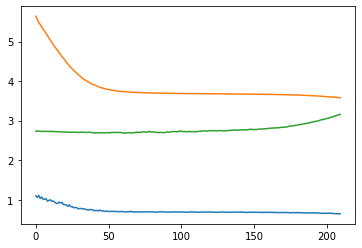

In [12]:
plt.plot(loss_list)
plt.plot(test_loss_list)
plt.plot(auc_score_list)
plt.show()